<a href="https://colab.research.google.com/github/LuizFFonseca/Trabalho_final_AM/blob/Dev---FE---healthy/Trabalho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.1 MB/s eta 0:00:00


In [2]:
from google.colab import drive
import os
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50, DenseNet121, Xception
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, RandomFlip, RandomRotation, RandomContrast, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt
from time import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from scipy.signal import stft
from sklearn.metrics import accuracy_score
import librosa
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder


In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


# Import

In [4]:
data = pd.read_pickle("/content/drive/MyDrive/Scripts/Pos/Aprendizadomaquina/Trabalho_final/data/cwru.pkl")
print(data.shape)
data.head()

(161, 9)


,fault_type,fault_location,fault_size,load,label,12K,DE,FE,BA
0,ball,DE,7,0,3,True,"[-0.0027613972055888225, -0.09632403193612774,...","[-0.24716181818181818, 0.14279090909090908, 0....","[0.015531632047477748, 0.016939940652818994, -..."
1,ball,DE,7,1,3,True,"[-0.07212119760479042, 0.30310395209580837, 0....","[0.07745636363636363, 0.045610909090909084, -0...","[0.07327228486646885, 0.06932902077151336, 0.0..."
2,ball,DE,7,2,3,True,"[-0.3144744111776447, 0.12198878243512974, 0.3...","[0.1479272727272727, -0.044994545454545454, 0....","[-0.01126646884272997, 0.02265364985163205, 0...."
3,ball,DE,7,3,3,True,"[0.09031393213572854, 0.22497265469061875, -0....","[0.07232, -0.007807272727272727, 0.12327272727...","[-0.05460213649851632, -0.05778089020771514, -..."
4,ball,DE,14,0,0,True,"[-0.46781317365269465, 0.1790035129740519, 0.4...","[0.09697454545454545, 0.27058363636363636, 0.1...","[0.0016497329376854602, 0.08047477744807123, 0..."


In [5]:
 # Defining labels
labels = pd.Series([data['fault_type'][i] + '-' + str(data['fault_size'][i])
                    for i in range(len(data))])
classes = sorted(labels.unique())
classes

['ball-14',
 'ball-21',
 'ball-28',
 'ball-7',
 'inner-14',
 'inner-21',
 'inner-28',
 'inner-7',
 'normal-0',
 'outer-14',
 'outer-21',
 'outer-7']

# Analise exploratoria

## Separando uma amostra de cada classe para os plots

In [6]:
to_plot = data[(data['fault_location'] == 'DE') &
          (data['load'] == '3')
          | (data['fault_location'] == 'normal') &
          (data['load'] == '3')]

# to_plot = to_plot[to_plot['12K'] == True]

to_plot = to_plot.drop_duplicates(subset=['fault_type', 'fault_size'], keep='first')

to_plot

,fault_type,fault_location,fault_size,load,label,12K,DE,FE,BA
3,ball,DE,7,3,3,True,"[0.09031393213572854, 0.22497265469061875, -0....","[0.07232, -0.007807272727272727, 0.12327272727...","[-0.05460213649851632, -0.05778089020771514, -..."
7,ball,DE,14,3,0,True,"[0.1054203992015968, -0.10736962075848304, -0....","[0.20463272727272727, 0.24839454545454545, 0.0...","[0.0493712759643917, 0.06248866468842731, 0.04..."
11,ball,DE,21,3,1,True,"[0.07244606786427145, 0.04791836327345309, -0....","[0.11977999999999998, 0.15059818181818183, 0.0...","[-0.07295038575667656, -0.09145958456973295, -..."
15,ball,DE,28,3,2,True,"[-6.5584142, 4.0616758, 7.613099, -2.2330672, ...",None,None
19,inner,DE,7,3,7,True,"[0.2226985628742515, 0.09323776447105789, -0.1...","[-0.09738545454545454, -0.1808, -0.23360181818...","[0.07741673590504453, -0.0024142433234421367, ..."
23,inner,DE,14,3,4,True,"[-0.009908542914171658, 0.06919736526946108, -...","[-0.028558181818181816, -0.11895818181818181, ...","[0.055447121661721076, -0.009133887240356084, ..."
27,inner,DE,21,3,5,True,"[-0.2062926147704591, -0.007309580838323354, 0...","[-0.21264545454545453, -0.12265636363636362, 0...","[-0.06502362017804154, -0.04796296735905045, -..."
31,inner,DE,28,3,6,True,"[-0.9338355, -0.5749497, 0.3812653, 1.1918101,...",None,None
35,outer,DE,7,3,11,True,"[0.16438435129740517, 0.2150641117764471, -0.2...","[-0.08752363636363636, 0.40659454545454543, -0...","[0.002092344213649852, 0.0009656973293768547, ..."
47,outer,DE,14,3,9,True,"[-0.15443784431137725, 0.02866275449101796, -0...","[0.03800909090909091, -0.035954545454545454, 0...","[0.005834421364985164, -0.011427418397626114, ..."


## Plots

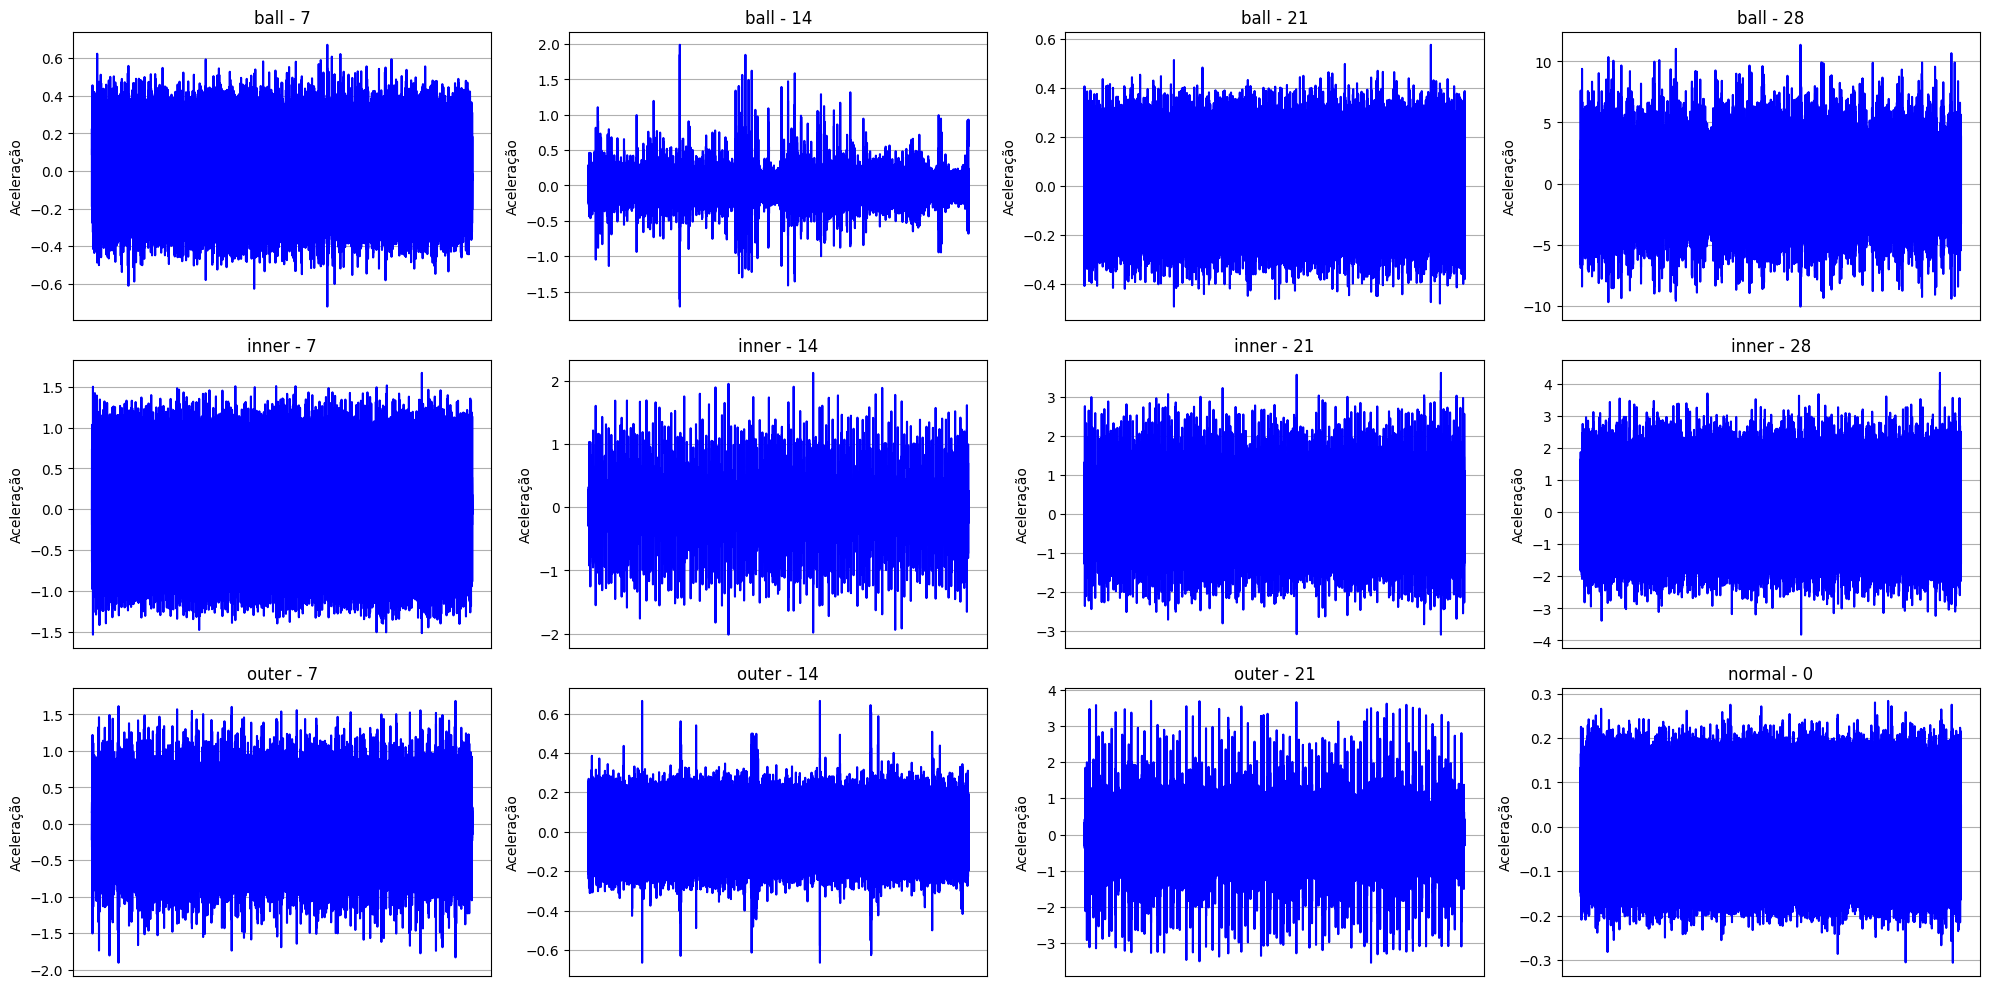

In [12]:
to_plot = to_plot.reset_index(drop=True)

# Definindo o tamanho da figura e a grade de subplots (3 linhas x 4 colunas)
fig, axes = plt.subplots(3, 4, figsize=(20, 10))

# Iterar sobre cada linha do DataFrame e cada eixo do subplot
for index, row in to_plot.iterrows():
    lista = row['DE']
    titulo = f"{row['fault_type']} - {row['fault_size']}"

    # Encontrar a posição do subplot
    ax = axes[index // 4, index % 4]  # Divisão inteira para linha e módulo para coluna
    # Plotar a lista no gráfico
    ax.plot(lista, color='b')
    ax.set_title(titulo)
    # ax.set_xlabel('Índice')
    ax.set_xticks([])
    ax.set_ylabel('Aceleração')
    ax.grid(True)

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Mostrar o gráfico
plt.show()

## Função para downsample

Artigo aplica um downsample para uma amostragem de 6kHz

In [13]:
def downsample(df, f_sample = 12e3):
  df_final = pd.DataFrame(columns = ['data', 'label'])
  for index, row in df.iterrows():
    sr_12k = 12e3  # Taxa de amostragem se 'coluna_boolean' for True
    sr_48k = 48e3  # Taxa de amostragem se 'coluna_boolean' for False

    DE = row['DE'] #Identificar dados DE
    FE = row['FE'] #Identificar dados FE
    BA = row['BA'] #Identificar dados BA

    sr_original = sr_12k if row['12K'] else sr_48k

    data = []

    if DE is not None:
      DE = np.array(row['DE'])
      data.append(DE)

    if FE is not None:
      FE = np.array(row['FE'])
      data.append(FE)

    if BA is not None:
      BA = np.array(row['BA'])
      data.append(BA)

    data_downsampled = []
    for sinal in data:
      # print(sinal)
      sinal = np.array(sinal)
      down_sample = librosa.resample(sinal, orig_sr=sr_original, target_sr=f_sample)

      data_downsampled.append(down_sample)

    df_temp = pd.DataFrame(data_downsampled)

    df_temp = df_temp.apply(lambda row: np.array(row[~np.isnan(row)] ,dtype = float), axis=1)

    df_temp = df_temp.to_frame(name='data')

    df_temp['label'] = row['label']

    df_final = pd.concat([df_final, df_temp])

  df_final = df_final.reset_index(drop=True)
  return df_final


df_downsampled = downsample(to_plot)
df_downsampled.head()

,data,label
0,"[0.09031393213572854, 0.22497265469061875, -0....",3
1,"[0.07232, -0.007807272727272727, 0.12327272727...",3
2,"[-0.05460213649851632, -0.05778089020771514, -...",3
3,"[0.1054203992015968, -0.10736962075848304, -0....",0
4,"[0.20463272727272727, 0.24839454545454545, 0.0...",0


## Segmentação


Além da mudança na amostragem é feito uma segmentação com tamanho de 1600 pontos

In [45]:
def segment_signal(signal, window_size, overlap=0):
    """
    Segmenta um sinal em janelas de tamanho fixo, com uma sobreposição opcional.

    Parâmetros:
        signal (array-like): O sinal a ser segmentado (lista ou numpy array).
        window_size (int): O tamanho de cada segmento (janela).
        overlap (int, opcional): O número de amostras que devem sobrepor entre janelas.
                                 Por padrão é 0 (sem sobreposição).

    Retorno:
        list: Uma lista contendo as janelas segmentadas do sinal.
    """
    if window_size <= 0:
        raise ValueError("O tamanho da janela deve ser maior que zero.")
    if overlap >= window_size:
        raise ValueError("A sobreposição deve ser menor que o tamanho da janela.")

    step = window_size - overlap
    segments = [signal[i:i + window_size] for i in range(0, len(signal) - window_size + 1, step)]

    return segments

In [46]:
def segmentação(df, tamanho_segmento = 1600):
  df_final = pd.DataFrame(columns = ['data', 'label'])
  for index, row in df.iterrows():
    data = row['data']
    label = row['label']



    segmentos = segment_signal(data,tamanho_segmento,0)

    for segmento in segmentos:

      df_temp = pd.DataFrame({'data': [segmento], 'label': [label]})
      df_final = pd.concat([df_final, df_temp])

  df_final = df_final.reset_index(drop=True)

  return df_final

df_segmentado = segmentação(df_downsampled)
df_segmentado.head()


,data,label
0,"[0.09031393213572854, 0.22497265469061875, -0....",3
1,"[-0.1780289021956088, -0.1954094610778443, 0.1...",3
2,"[0.21993716566866267, -0.049380279441117766, -...",3
3,"[0.3180479840319361, -0.26282003992015973, -0....",3
4,"[-0.1791659481037924, -0.1052579640718563, 0.2...",3


## STFT

In [16]:
def get_stft(df, janela = 128, passo = 32):
  df_final = pd.DataFrame(columns = ['stft', 'label'])
  for index, row in df.iterrows():
    data = row['data']
    label = row['label']
    noverlap = janela - passo

    # Aplicar a transformada STFT
    f, t, stft_result = stft(np.array(data),fs = 12000 ,nperseg = janela, noverlap = noverlap)

    df_temp = pd.DataFrame({'stft': [np.delete(np.abs(stft_result),-1,1)], 'label': [label]})

    df_final = pd.concat([df_final, df_temp])

  df_final = df_final.reset_index(drop=True)

  return df_final

df_stft = get_stft(df_segmentado)
df_stft.head()


,stft,label
0,"[[0.0046627964379330165, 0.004969686013366023,...",3
1,"[[0.0036535953150725136, 0.002209305257292351,...",3
2,"[[0.003896214181431377, 0.002196604235786035, ...",3
3,"[[0.0027944988184996147, 0.005684842785698682,...",3
4,"[[0.009487218032625885, 0.004989715404617692, ...",3


In [17]:
df_stft["label"].value_counts()

,count
label,
7,456
0,453
1,453
4,453
5,453
11,453
9,453
10,453
3,450


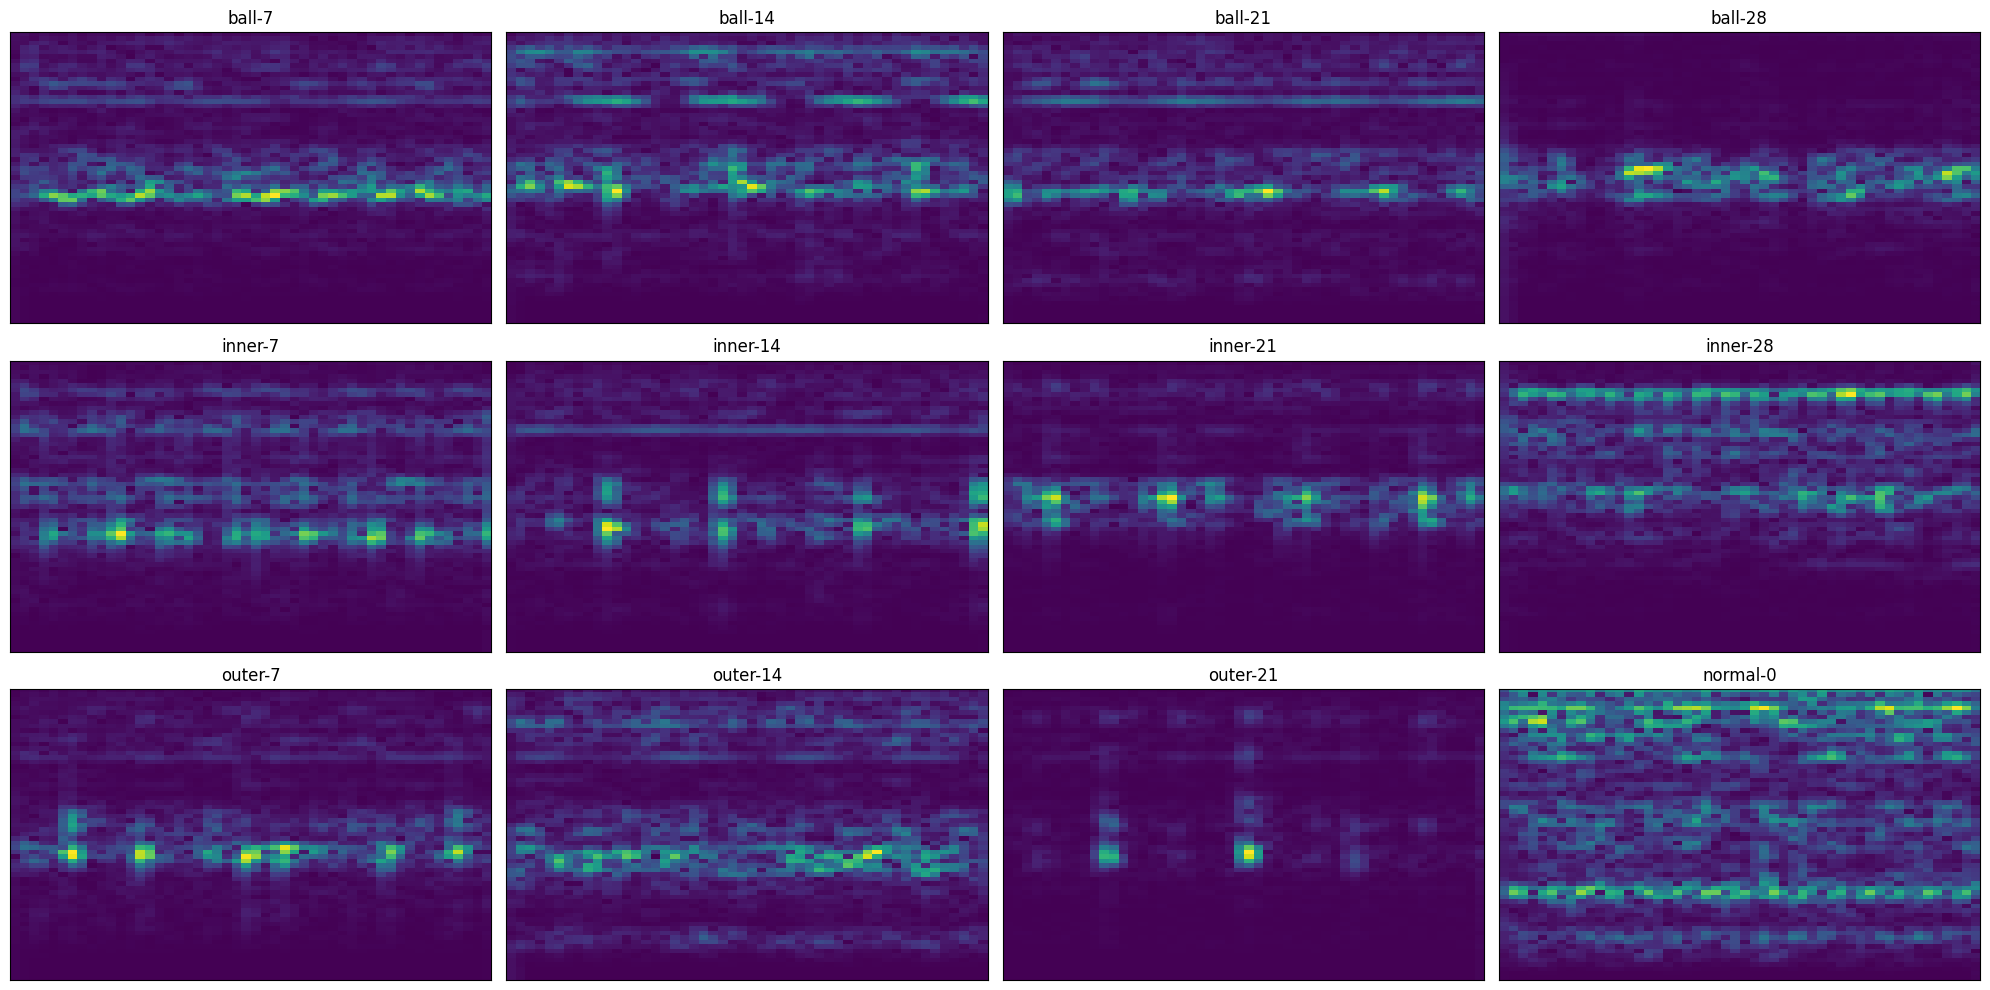

In [18]:
to_plot = df_stft.drop_duplicates(subset=['label'], keep='first')

to_plot = to_plot.reset_index(drop=True)

# Definindo o tamanho da figura e a grade de subplots (3 linhas x 4 colunas)
fig, axes = plt.subplots(3, 4, figsize=(20, 10))

# Iterar sobre cada linha do DataFrame e cada eixo do subplot
for index, row in to_plot.iterrows():
    matriz = row['stft']
    titulo = f"{classes[int(row['label'])]}"

    # Encontrar a posição do subplot
    ax = axes[index // 4, index % 4]  # Divisão inteira para linha e módulo para coluna

    # Plotar a matriz 2D usando imshow
    cax = ax.imshow(np.abs(matriz), cmap='viridis', aspect='auto')
    ax.set_title(titulo)
    ax.set_xticks([])
    ax.set_yticks([])

    # Adicionar uma barra de cor para cada subplot
    # fig.colorbar(cax, ax=ax)

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Mostrar o gráfico
plt.show()

In [19]:
df_stft[df_stft['label'] == 8]['stft'].iloc[0].shape

(65, 50)

In [20]:
df_stft[df_stft['label'] == 0]['stft'].iloc[0].shape

(65, 50)

# Preparação dos dados

In [42]:
# prompt: Gere um codigo que olhe para a df dados e verifique se a fault_location é DE caso seja vai pegar o sinal da coluna FE concatenar no fim da df com as outras colunas com o mesmo valor, mudando o fault_type e fault_location para normal e o label para 8

def process_de_fault(df):
  """
  Processes rows where 'fault_location' is 'DE'.

  For rows with 'fault_location' as 'DE', it concatenates the 'FE' signal
  to the end of the DataFrame, modifies other columns, and returns the new DataFrame.
  """
  new_rows = []
  for index, row in df.iterrows():
    if row['fault_location'] == 'DE':
      if row['FE'] is not None:  # Check if 'FE' column has a value
          new_row = row.copy()
          new_row['DE'] = None # Concatenate FE signal to data
          row['FE'] = None
          new_row['fault_type'] = 'normal'
          new_row['fault_location'] = 'normal'
          new_row['label'] = 8
          new_rows.append(row)
          new_rows.append(new_row)
    else:
        new_rows.append(row)
  return pd.DataFrame(new_rows)

In [43]:
dados = data[(data['fault_location'] == 'DE') | (data['fault_location'] == 'normal') ]
dados = df_processed = process_de_fault(dados)
# dados.loc[(data['fault_location'] == 'DE'), 'FE'] = None
dados.loc[(data['fault_location'] == 'DE'), 'BA'] = None
dados

,fault_type,fault_location,fault_size,load,label,12K,DE,FE,BA
0,ball,DE,7,0,3,True,"[-0.0027613972055888225, -0.09632403193612774,...",None,None
0,normal,normal,7,0,8,True,None,"[-0.24716181818181818, 0.14279090909090908, 0....",None
1,ball,DE,7,1,3,True,"[-0.07212119760479042, 0.30310395209580837, 0....",None,None
1,normal,normal,7,1,8,True,None,"[0.07745636363636363, 0.045610909090909084, -0...",None
2,ball,DE,7,2,3,True,"[-0.3144744111776447, 0.12198878243512974, 0.3...",None,None
...,...,...,...,...,...,...,...,...,...
156,normal,normal,21,3,8,False,None,"[0.10028646464646465, 0.04356707070707071, -0....",None
157,normal,normal,0,3,8,False,"[0.014603076923076923, 0.05444861538461539, 0....","[0.19292181818181817, 0.16436363636363635, 0.0...",None
158,normal,normal,0,0,8,False,"[0.05319692307692307, 0.08866153846153846, 0.0...","[0.14566727272727273, 0.09779636363636364, 0.0...",None
159,normal,normal,0,1,8,False,"[0.046104, -0.03713353846153846, -0.0894959999...","[0.023216363636363632, 0.08115454545454545, 0....",None


In [44]:
dados['fault_location'].value_counts()

,count
fault_location,
normal,108
DE,104


In [47]:
df_downsampled = downsample(dados)
df_segmentacao = segmentação(df_downsampled)
df = get_stft(df_segmentacao)
df.head()

,stft,label
0,"[[0.01157540145002548, 0.01762599445935281, 0....",3
1,"[[0.0010559130214167268, 0.011062785048560776,...",3
2,"[[0.006196306520358481, 0.01356841395415791, 0...",3
3,"[[0.005922853654603378, 0.013537865620645151, ...",3
4,"[[0.013770271888472128, 0.015697316244233477, ...",3


In [48]:
df.iloc[0]['stft'].shape

(65, 50)

In [49]:
df.shape

(15062, 2)

In [50]:
df['label'].value_counts()

,count
label,
8,7794
10,1671
11,1665
1,570
0,569
9,569
5,568
3,567
7,566


In [ ]:
df.to_pickle("/content/drive/MyDrive/Scripts/Pos/Aprendizadomaquina/Trabalho_final/data/stft.pkl")

In [ ]:
df = pd.read_pickle("/content/drive/MyDrive/Scripts/Pos/Aprendizadomaquina/Trabalho_final/data/stft.pkl")

# Separação dos dados

In [51]:
def sample_labels_exact(df, label_col, n_samples):
    """
    Mantém exatamente `n_samples` amostras para cada valor na coluna `label_col`.

    Parâmetros:
        df (pd.DataFrame): O DataFrame original.
        label_col (str): O nome da coluna de rótulos (labels).
        n_samples (int): O número de amostras a manter para cada label.

    Retorno:
        pd.DataFrame: Um novo DataFrame com as amostras selecionadas.
    """
    sampled_df = (
        df.groupby(label_col, group_keys=False)
          .apply(lambda x: x.sample(n=n_samples, random_state=42))
    )
    return sampled_df.reset_index(drop=True)


In [52]:
def prepare_data(series):
    """
    Prepara uma série contendo arrays 2D para entrada em um modelo.

    Args:
        series (pd.Series): Série com arrays 2D do NumPy.

    Returns:
        np.ndarray: Array 4D pronto para ser usado como entrada do modelo.
    """
    # Verificar a consistência das dimensões
    shapes = series.apply(lambda x: x.shape)
    if not all(shape == shapes.iloc[0] for shape in shapes):
        raise ValueError("Todos os arrays devem ter dimensões consistentes.")

    # Expandir a dimensão para incluir o canal (1 para escala de cinza)
    arrays = series.apply(lambda x: np.expand_dims(x, axis=-1)).values

    # Consolidar em um único array 4D
    data = np.stack(arrays, axis=0)

    # Normalizar os valores (ajuste conforme necessário para seu modelo)
    # data = data / 255.0  # Normalizando para [0, 1]

    return data

In [54]:
df_sampled = sample_labels_exact(df, 'label', 500)
df_sampled['label'].value_counts()

<ipython-input-51-c9f960b04259>:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=n_samples, random_state=42))


,count
label,
0,500
1,500
3,500
4,500
5,500
7,500
8,500
9,500
10,500


In [55]:
df_train, df_test = train_test_split(df_sampled,train_size=0.5,stratify=df_sampled['label'], random_state= 42)
df_val, df_test = train_test_split(df_test, train_size = 1/3, stratify=df_test['label'], random_state= 42)



X_train = prepare_data(df_train['stft'])
y_train = to_categorical(df_train['label'], num_classes=12)
df_train['label'].value_counts()

,count
label,
1,250
8,250
7,250
11,250
4,250
9,250
0,250
5,250
10,250


In [56]:
X_val = prepare_data(df_val['stft'])
y_val = to_categorical(df_val['label'], num_classes=12)
df_val['label'].value_counts()

,count
label,
7,84
10,84
1,84
8,83
5,83
9,83
3,83
4,83
11,83


In [57]:
X_test = prepare_data(df_test['stft'])
y_test = to_categorical(df_test['label'], num_classes=12)
df_test['label'].value_counts()

,count
label,
0,167
5,167
3,167
9,167
8,167
11,167
4,167
7,166
10,166


In [58]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(2500, 65, 50, 1)
(833, 65, 50, 1)
(1667, 65, 50, 1)
(2500, 12)
(833, 12)
(1667, 12)


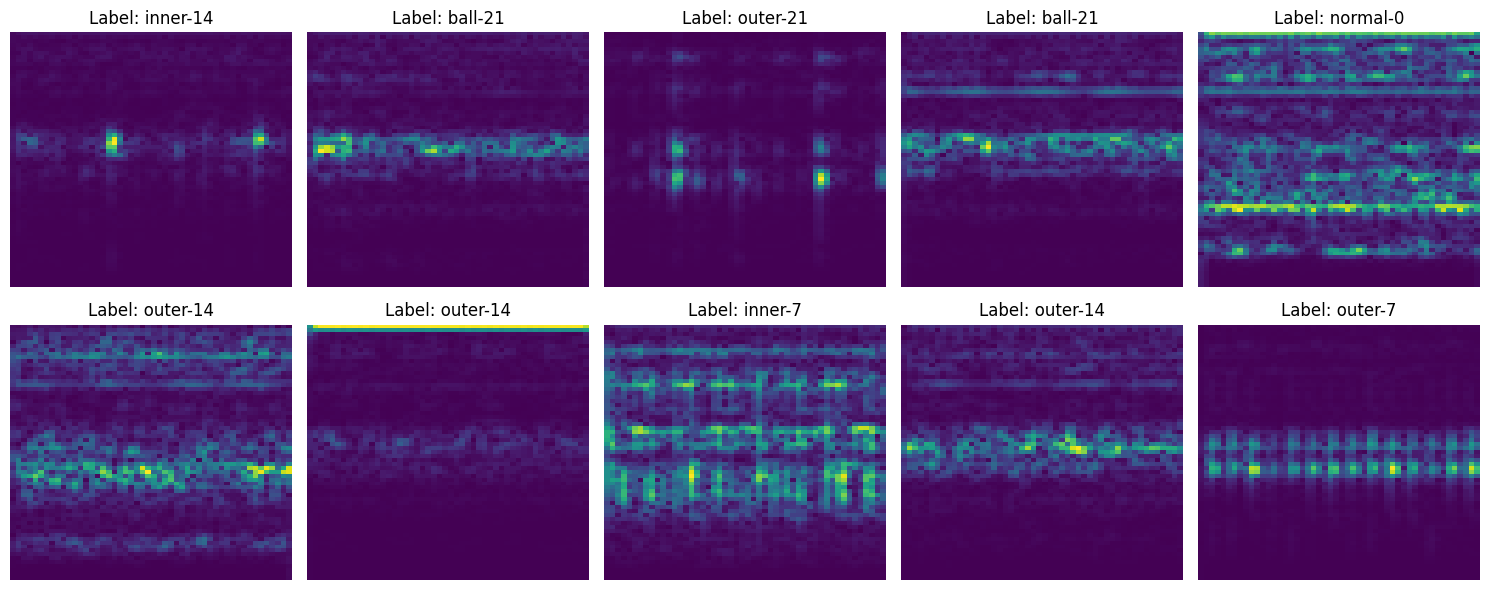

In [59]:
# prompt: Pegue o X_train que possui 3600 espcrtogramas, e plote 10 aleatorios em um grid 2x5

import matplotlib.pyplot as plt
import random

# Seleciona 10 índices aleatórios
indices_aleatorios = random.sample(range(X_train.shape[0]), 10)

# Cria uma figura com uma grade 2x5
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Itera sobre os índices aleatórios e plota os espectrogramas
for i, index in enumerate(indices_aleatorios):
    row = i // 5
    col = i % 5

    # Get the label (convert from categorical to integer)
    label = classes[np.argmax(y_train[index])]

    axes[row, col].imshow(X_train[index, :, :, 0], cmap='viridis', aspect='auto')
    axes[row, col].set_title(f"Label: {label}")  # Include label in title
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# Montar modelos

In [60]:
CNN3 = Sequential([
    Input((65,50,1)),
    Conv2D(32, (3, 3), activation='relu',strides= 1, padding = 'same'),
    Conv2D(64, (1, 1), activation='relu',strides= 1, padding = 'same'),
    Conv2D(32, (3, 3), activation='relu',strides= 1, padding = 'same'),
    Conv2D(64, (1, 1), activation='relu',strides= 1, padding = 'same'),
    Conv2D(32, (3, 3), activation='relu',strides= 1, padding = 'same'),
    Conv2D(64, (1,1), activation='relu',strides= 1, padding = 'same'),
    Conv2D(1, (1,1), activation='relu',strides= 1, padding = 'same'),
    Flatten(),

    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(12, activation='softmax')

])

@tf.function
def model_fn(input_tensor):
    return CNN3(input_tensor)


input_shape = (1, 65, 50, 1)  # Exemplo de entrada
dummy_input = tf.random.normal(input_shape)

concrete_function = model_fn.get_concrete_function(dummy_input)
options = ProfileOptionBuilder.float_operation()  # Opção para calcular FLOPS
profile_info = profile(concrete_function.graph, options=options)
flops = profile_info.total_float_ops
print(f"FLOPS totais: {flops*1e-9:.4f} (G)")

CNN3.summary()

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


FLOPS totais: 0.2846 (G)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 65, 50, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 65, 50, 64)          │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 65, 50, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 65, 50, 64)          │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 65, 50, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 65, 50, 64)          │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 65, 50, 1)           │              65 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3250)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         832,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 12)                  │           3,084 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 944,781 (3.60 MB)

 Trainable params: 944,781 (3.60 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
CNN2 = Sequential([
    Input((65,50,1)),
    Conv2D(32, (3, 3), activation='relu',strides= 1, padding = 'same'),
    Conv2D(64, (1, 1), activation='relu',strides= 1, padding = 'same'),
    Conv2D(32, (3, 3), activation='relu',strides= 1, padding = 'same'),
    Conv2D(64, (1,1), activation='relu',strides= 1, padding = 'same'),
    Conv2D(1, (1,1), activation='relu',strides= 1, padding = 'same'),
    Flatten(),

    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(12, activation='softmax')

])

@tf.function
def model_fn(input_tensor):
    return CNN2(input_tensor)


input_shape = (1, 65, 50, 1)  # Exemplo de entrada
dummy_input = tf.random.normal(input_shape)

concrete_function = model_fn.get_concrete_function(dummy_input)
options = ProfileOptionBuilder.float_operation()  # Opção para calcular FLOPS
profile_info = profile(concrete_function.graph, options=options)
flops = profile_info.total_float_ops
print(f"FLOPS totais: {flops*1e-9:.4f} (G)")

CNN2.summary()

FLOPS totais: 0.1511 (G)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 65, 50, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 65, 50, 64)          │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 65, 50, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 65, 50, 64)          │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 65, 50, 1)           │              65 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3250)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         832,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 12)                  │           3,084 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 924,205 (3.53 MB)

 Trainable params: 924,205 (3.53 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
liteCNN = Sequential([
    Input((65,50, 1)),
    Conv2D(32, (3, 3), activation='relu', strides= 1, padding = 'same' ),
    Conv2D(64, (1, 1), activation='relu', strides= 1, padding = 'same' ),
    Conv2D(1, (1, 1), activation='relu', strides= 1, padding = 'same' ),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(12, activation='softmax')

])

@tf.function
def model_fn(input_tensor):
    return liteCNN(input_tensor)


input_shape = (1, 65, 50, 1)  # Exemplo de entrada
dummy_input = tf.random.normal(input_shape)

concrete_function = model_fn.get_concrete_function(dummy_input)
options = ProfileOptionBuilder.float_operation()  # Opção para calcular FLOPS
profile_info = profile(concrete_function.graph, options=options)
flops = profile_info.total_float_ops
print(f"FLOPS totais: {flops*1e-9:.4f} (G)")

liteCNN.summary()

FLOPS totais: 0.0177 (G)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 65, 50, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 65, 50, 64)          │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 65, 50, 1)           │              65 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 3250)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         832,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 12)                  │           3,084 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 903,629 (3.45 MB)

 Trainable params: 903,629 (3.45 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
CNN0 = Sequential([
    Input((65,50,1)),
    Flatten(),

    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(12, activation='softmax')

])

@tf.function
def model_fn(input_tensor):
    return CNN0(input_tensor)


input_shape = (1, 65, 50, 1)  # Exemplo de entrada
dummy_input = tf.random.normal(input_shape)

concrete_function = model_fn.get_concrete_function(dummy_input)
options = ProfileOptionBuilder.float_operation()  # Opção para calcular FLOPS
profile_info = profile(concrete_function.graph, options=options)
flops = profile_info.total_float_ops
print(f"FLOPS totais: {flops*1e-9:.4f} (G)")

CNN0.summary()

FLOPS totais: 0.0018 (G)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)                  │ (None, 3250)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │         832,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 12)                  │           3,084 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 901,132 (3.44 MB)

 Trainable params: 901,132 (3.44 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
input_shape = (65, 50, 1)


# 1. Create the ResNet50 base model
base_model = ResNet50(weights=None, include_top=False, input_shape=input_shape)

# 2. Add Global Average Pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# 3. Add a fully connected layer
# x = Dense(1000, activation='relu')(x)
x = Dense(12, activation='softmax')(x)  # Assuming 12 output classes

ResNet = Model(inputs=base_model.input, outputs=x)

@tf.function
def model_fn(input_tensor):
    return ResNet(input_tensor)


input_shape = (1, 65, 50, 1)  # Exemplo de entrada
dummy_input = tf.random.normal(input_shape)

concrete_function = model_fn.get_concrete_function(dummy_input)
options = ProfileOptionBuilder.float_operation()  # Opção para calcular FLOPS
profile_info = profile(concrete_function.graph, options=options)
flops = profile_info.total_float_ops
print(f"FLOPS totais: {flops*1e-9:.4f} (G)")


FLOPS totais: 0.7179 (G)


# Treinamento preliminar

In [65]:
models = [
    CNN3,
    CNN2,
    liteCNN,
    CNN0,
    ResNet
    ]

names = [
    'CNN3',
    'CNN2',
    'liteCNN',
    'CNN0',
    'ResNet'
    ]

In [66]:
def plots(history, xlim=None, ylim=None, name = None):
  if hasattr(history, 'history'):
    history = history.history
  plt.figure(figsize=(14, 4))
  plt.subplot(1, 2, 1)
  plt.plot(history['loss'], '.-', label='Train loss')
  if 'val_loss' in history.keys():
    plt.plot(history['val_loss'], '.-', label='Val loss')
  plt.xlabel('Epochs');
  plt.legend();
  plt.yscale('log')
  plt.grid(which='both');
  plt.subplot(1, 2, 2)
  plt.plot(history['accuracy'], '.-', label='Train accuracy')
  plt.xlabel('Epochs');
  if 'val_accuracy' in history.keys():
    plt.plot(history['val_accuracy'], '.-', label='Val accuracy')
    plt.title(f"Val accuracy: {np.max(history['val_accuracy']):.1%} (best) | {history['val_accuracy'][-1]:.1%} (last)");
  plt.legend();
  plt.xlim(xlim);
  plt.ylim(ylim);
  if name is not None:
    plt.title(name)
  plt.grid();
  plt.show();

In [67]:
def train(model, epochs, batch_size, lr, callbacks):
  from tqdm.keras import TqdmCallback
  callbacks = callbacks + [TqdmCallback(verbose=0)]
  # Change loss function to 'categorical_crossentropy'
  model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=lr))
  history = model.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_val, y_val), verbose=0, callbacks=callbacks, epochs=epochs)
  return history

In [68]:
from tensorflow.keras.callbacks import EarlyStopping

In [69]:
for i, model in enumerate(models):
  history = train(model, epochs=25, batch_size=256, lr=0.001, callbacks=[EarlyStopping(patience=10)])
  plots(history, ylim=[0.8, 0.96], name = names[i])

0epoch [00:00, ?epoch/s]

KeyboardInterrupt: 

# Otimização de Hiperparametros

In [ ]:
def create_hypermodel(base_model_fn):
    """
    Gera uma função hypermodel para Keras Tuner.

    Args:
        base_model_fn (function): Uma função que retorna um modelo Keras.

    Returns:
        function: Uma função para ser usada com Keras Tuner.
    """
    def hypermodel_builder(hp):
        """
        Função que define e retorna o modelo com hiperparâmetros ajustáveis.

        Args:
            hp (HyperParameters): Objeto que permite definir os hiperparâmetros.

        Returns:
            model: O modelo compilado com os hiperparâmetros definidos.
        """
        # Obtém o modelo base
        model = base_model_fn

        hp_learning_rate = hp.Choice('learning_rate', values=[1e-0, 1e-1, 1e-2, 1e-3, 1e-4])
        hp_batch_size = hp.Choice('batch_size', values=[32,64,128,256,512]) # Define batch_size como hiperparâmetro

        model.compile(
            optimizer=Adam(learning_rate=hp_learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

    return hypermodel_builder



In [ ]:
for i, model in enumerate(models):

    print(f'Otimização de hiperparametros do modelo {names[i]}')

    hypermodel_builder = create_hypermodel(model)

    ##Configuração do tuner e otimização dos hiperparametros em questão (tamanho do batch e taxa de aprendizado)
    tuner = kt.GridSearch(hypermodel = hypermodel_builder,
        objective='val_accuracy',
        # directory = '/content/drive/MyDrive/Scripts/Pos/Aprendizadomaquina/Trabalho_final/Results',
        # project_name = names[i]
    )

    # Adicionar o batch size como hiperparâmetro ajustável
    def run_tuning(tuner):
        tuner.search(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        )

    # Executar a busca
    run_tuning(tuner)

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f"Melhor tamanho de batch: {best_hps.get('batch_size')}")
    print(f"Melhor taxa de aprendizado: {best_hps.get('learning_rate')}")

Trial 2 Complete [00h 00m 36s]
val_accuracy: 0.0833333358168602

Best val_accuracy So Far: 0.0833333358168602
Total elapsed time: 00h 01m 23s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
1                 |1                 |learning_rate
128               |32                |batch_size

Epoch 1/10


KeyboardInterrupt: 